## Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=0
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import os                                                                       
import re
import time as ti
import numpy as np                                                              
import matplotlib.pyplot as plt
import scipy
import tensorflow as tf                                                         
import data.data_selector as ds                                                   
import utils.plot_functions as pf                                               
import analysis.analysis_picker as ap
from utils.logger import Logger

In [9]:
params = {
  "model_type": "sparse_autoencoder",
  "model_name": "sparse_autoencoder",
  "version": "0.0",
  "weights": ["w_dec"]}
  #"weights": ["w_synth"]}
  #"weights": ["w_analysis"]}
params["model_dir"] = (os.path.expanduser("~")+"/Work/Projects/"
  +params["model_name"])

Current step:  10000


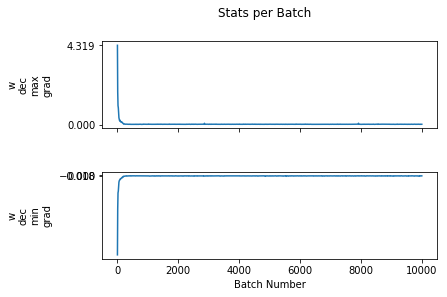

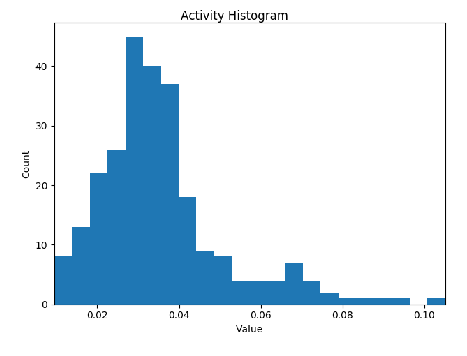

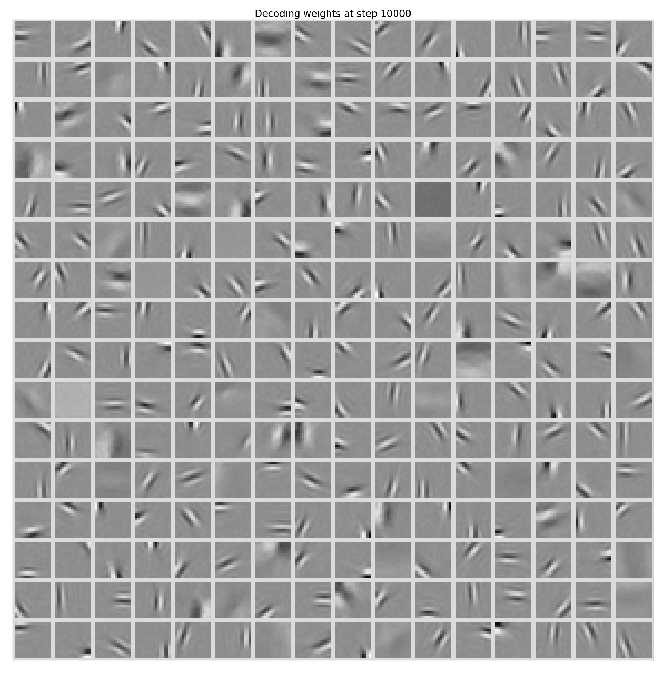

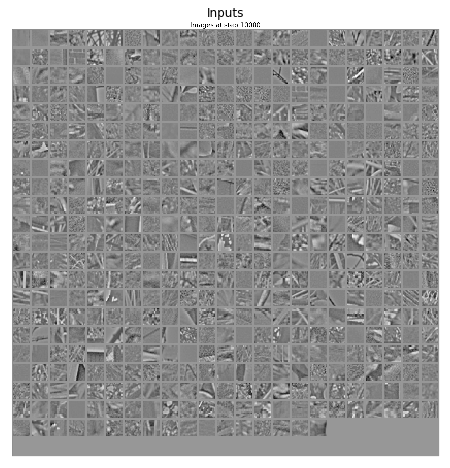

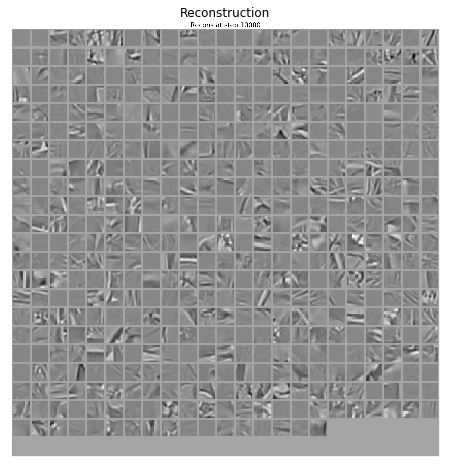

In [14]:
log_file = (params["model_dir"]+"/logfiles/"+params["model_name"]+"_v"+params["version"]+".log")
logger = Logger()
log_text = logger.load_file(log_file)
model_params = logger.read_params(log_text)
model_schedule = logger.read_schedule(log_text)
#print("target_act: ", model_schedule[0]["target_act"])
#print("decay_mult: ", model_schedule[0]["decay_mult"])
#print("sparse_mult: ", model_schedule[0]["sparse_mult"])

vis_dir = (model_params["out_dir"]+model_params["model_name"]+"/vis/")
vis_files = [file for file in os.listdir(vis_dir)]
indices = sorted([(mid, int(match.group(1)))
  for mid, match in
  enumerate([re.search("-(\d+)",filename) for filename in vis_files])
  if match], key=lambda x:x[1])
if len(vis_files) > 0:
  current_step = indices[-1][-1]
  prev_step = current_step
else:
  current_step = 0
  prev_step = 0
if current_step == prev_step:
  pass 
prev_step = current_step
print("Current step: ", current_step)
  
model_stats = logger.read_stats(log_text)
stats_keys = []
#stats_keys += ["a_fraction_active"]
#stats_keys += [key for key in model_stats if "loss" in key]
stats_keys += [weight+"_max_grad" for weight in params["weights"]]
stats_keys += [weight+"_min_grad" for weight in params["weights"]]
#stats_keys += ["total_loss"]
stats_fig = pf.plot_stats(model_stats, keys=stats_keys)

activity_details = "act_hist_v"+model_params["version"]
activity_files = [file for file in vis_files if activity_details in file]
if len(activity_files) > 0:
  indices = sorted([(mid, int(match.group(1)))
    for mid, match in
    enumerate([re.search("-(\d+)",filename) for filename in activity_files])
    if match], key=lambda x:x[1])
  disp_filename = vis_dir+activity_files[indices[-1][0]]
  act_hist = scipy.ndimage.imread(disp_filename)
  fig, ax = plt.subplots(1, figsize=(8,8))
  ax.imshow(act_hist)
  ax = pf.clear_axis(ax)
  plt.show()

def plot_weight_image(weight_details):
  weight_files = [file
    for file in vis_files
    if weight_details in file and "d"+w_name not in file]
  if len(weight_files) > 0:
    indices = sorted([(mid, int(match.group(1)))
      for mid, match in
      enumerate([re.search("-(\d+)",filename) for filename in weight_files])
      if match], key=lambda x:x[1])
    disp_filename = vis_dir+weight_files[indices[-1][0]]
    weights = scipy.ndimage.imread(disp_filename)
    fig, ax = plt.subplots(1, figsize=(12,12))
    ax.imshow(weights)
    ax = pf.clear_axis(ax)
    plt.show()
    
for w_name in params["weights"]:#["w_analysis"]:#params["weights"]:
  weight_details = w_name+"_v"+model_params["version"]+"-"
  plot_weight_image(weight_details)
  weight_details = w_name+"_unnormalized_v"+model_params["version"]+"-"
  plot_weight_image(weight_details)
  weight_details = w_name+"_norm_v"+model_params["version"]+"-"
  plot_weight_image(weight_details)
  

img_details = "images"
img_files = [file for file in vis_files if img_details in file]
if len(img_files) > 0:
  indices = sorted([(mid, int(match.group(1)))
    for mid, match in
    enumerate([re.search("-(\d+)",filename) for filename in img_files])
    if match], key=lambda x:x[1])
  disp_filename = vis_dir+img_files[indices[-1][0]]
  recon = scipy.ndimage.imread(disp_filename)
  fig, ax = plt.subplots(1, figsize=(8,8))
  ax.imshow(recon)
  ax = pf.clear_axis(ax)
  ax.set_title("Inputs")
  plt.show()

recon_details = "recons_v"+model_params["version"]
recon_files = [file for file in vis_files if recon_details in file]
if len(recon_files) > 0:
  indices = sorted([(mid, int(match.group(1)))
    for mid, match in
    enumerate([re.search("-(\d+)",filename) for filename in recon_files])
    if match], key=lambda x:x[1])
  disp_filename = vis_dir+recon_files[indices[-1][0]]
  recon = scipy.ndimage.imread(disp_filename)
  fig, ax = plt.subplots(1, figsize=(8,8))
  ax.imshow(recon)
  ax = pf.clear_axis(ax)
  ax.set_title("Reconstruction")
  plt.show()

In [11]:
#stats_keys = ["entropy_loss"]
#fig = pf.plot_stats(model_stats, keys=stats_keys)

In [8]:
#TODO: Update single fig
#  pf takes optional fig argument to update instead of make a new one?
#  if so, would need to make pf.imshow()
#logger = Logger()
#log_text = logger.load_file(log_file)
#model_params = logger.read_params(log_text)
#model_schedule = logger.read_schedule(log_text)
#
#vis_dir = (model_params["out_dir"]+model_params["model_name"]+"/vis/")
#
#complete = False
#current_step = 0
#print("Current step: ", current_step)
#while current_step <= np.sum([schedule["num_batches"] for schedule in model_schedule]) and not complete:
#  complete = current_step == np.sum([schedule["num_batches"] for schedule in model_schedule])
#  vis_files = [file for file in os.listdir(vis_dir)]
#  indices = sorted([(mid, int(match.group(1)))
#    for mid, match in
#    enumerate([re.search("-(\d+)",filename) for filename in vis_files])
#    if match], key=lambda x:x[1])
#  if len(vis_files) > 0:
#    current_step = indices[-1][-1]
#    prev_step = current_step
#  else:
#    current_step = 0
#    prev_step = 0
#  if current_step == prev_step:
#    pass 
#  prev_step = current_step
#  print("Current step: ", current_step)
#    
#  model_stats = logger.read_stats(log_text)
#  stats_keys = ["a_fraction_active", "phi_max_grad"] + [key for key in model_stats if "loss" in key]
#  stats_fig = pf.plot_stats(model_stats, keys=stats_keys)
#  
#  activity_details = "act_hist_v"+model_params["version"]
#  activity_files = [file for file in vis_files if activity_details in file]
#  if len(activity_files) > 0:
#    indices = sorted([(mid, int(match.group(1)))
#      for mid, match in
#      enumerate([re.search("-(\d+)",filename) for filename in activity_files])
#      if match], key=lambda x:x[1])
#    disp_filename = vis_dir+activity_files[indices[-1][0]]
#    act_hist = scipy.ndimage.imread(disp_filename)
#    fig, ax = plt.subplots(1, figsize=(8,8))
#    ax.imshow(act_hist)
#    ax = pf.clear_axis(ax)
#    plt.show()
#  
#  weight_details = "phi_v"+model_params["version"]+"_"
#  weight_files = [file for file in vis_files if weight_details in file and "dphi" not in file]
#  if len(weight_files) > 0:
#    indices = sorted([(mid, int(match.group(1)))
#      for mid, match in
#      enumerate([re.search("_(\d+)",filename) for filename in weight_files])
#      if match], key=lambda x:x[1])
#    disp_filename = vis_dir+weight_files[indices[-1][0]]
#    weights = scipy.ndimage.imread(disp_filename)
#    fig, ax = plt.subplots(1, figsize=(12,12))
#    ax.imshow(weights)
#    ax = pf.clear_axis(ax)
#    plt.show()
#  
#  recon_details = "recons_v"+model_params["version"]
#  recon_files = [file for file in vis_files if recon_details in file]
#  if len(recon_files) > 0:
#    indices = sorted([(mid, int(match.group(1)))
#      for mid, match in
#      enumerate([re.search("-(\d+)",filename) for filename in recon_files])
#      if match], key=lambda x:x[1])
#    disp_filename = vis_dir+recon_files[indices[-1][0]]
#    recon = scipy.ndimage.imread(disp_filename)
#    fig, ax = plt.subplots(1, figsize=(8,8))
#    ax.imshow(recon)
#    ax = pf.clear_axis(ax)
#    ax.set_title("Reconstruction")
#    plt.show()

In [9]:
log_int = model_params["log_int"]
plot_int = model_params["gen_plot_int"]

In [ ]:
num_in_avg = 3
time_list = [None,]*(num_in_avg)
for i in range(num_in_avg+1):
  log_mtime = os.stat(log_file).st_mtime
  start = np.floor(ti.clock())
  while np.floor(log_mtime) >= np.floor(os.stat(log_file).st_mtime):
    pass
  end = np.floor(ti.clock())
  if i > 0:
    time_list[i-1] = end - start
avg_time = np.mean(time_list)

log_mtime = os.stat(log_file).st_mtime
first_run = True
while True:
  ti.sleep(avg_time)
  if np.floor(os.stat(log_file).st_mtime) > np.floor(log_mtime):
    if first_run:
      stats_fig = pf.plot_stats(lp.read_stats(log_text),
        keys=["a_fraction_active", "recon_loss", "sparse_loss", "total_loss"],
        labels=["activity", "recon loss", "sparse loss", "total loss"])
    else:
      stats_fig.canvas.draw() 
      first_run = False
    log_mtime = os.stat(log_file).st_mtime

In [ ]:
img_dir = (model_params["out_dir"]+model_params["model_name"]+"/vis/")
file_details = "phi_v"+model_params["version"]+"_"
outputs = [file for file in os.listdir(img_dir) if file_details in file and "dphi" not in file]
indices = sorted([(mid, int(match.group(1)))
  for mid, match in
  enumerate([re.search("_(\d+)",output) for output in outputs])
  if match], key=lambda x:x[1])
disp_filename = img_dir+outputs[indices[-1][0]]
weights = scipy.ndimage.imread(disp_filename)
fig, ax = plt.subplots(1)
ax.imshow(weights)
ax = pf.clear_axis(ax)
plt.show()